# QGAN
Quantum Generative Adversarial Network capable of generating novel MNIST images. Created by QMIND's Disruptive Technology team consisting of Cameron Estabrooks, Jacob Ewaniuk, Adam Grace, Spencer Hill, and Joshua Otten. 

In [1]:
# Imports
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

from pennylane import numpy as np
from numpy import pi
from numpy import linalg as la

import pennylane as qml
import cirq
import math as m
import numpy as np

from sklearn.preprocessing import MinMaxScaler

res = 4
numQubits = 2 * res + 1
numWeights = 3 * res - 1
dev = qml.device('cirq.simulator', wires=numQubits)

# Data Loading and Preparation
Load MNIST data, normalize it, and create new arrays with only the 3 and 9 digits

In [2]:
# Utility function to display images 
def display_image(X_data, image_num, Y_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(image_num):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_data[i], cmap='Greys')
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        if Y_labels is not None:
            plt.xlabel(Y_labels[i])
    plt.show()

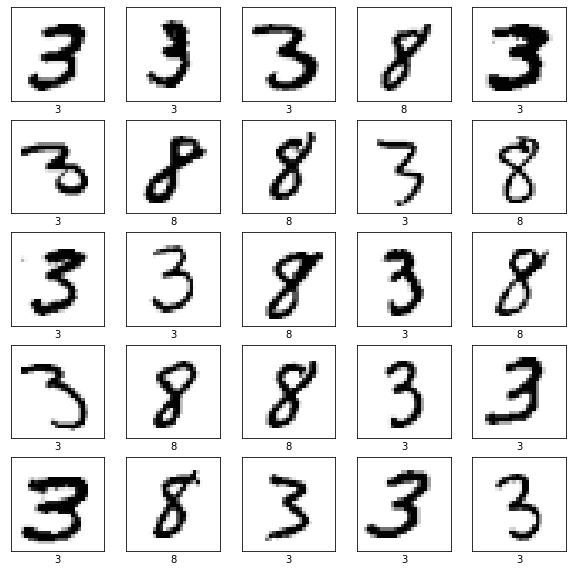

In [3]:
# Prepare and Load Data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
full_X = np.concatenate((X_train, X_test))
full_Y = np.concatenate((Y_train, Y_test))
full_X = full_X / 255
other_X = full_X[:10000] # Paper only uses first 10000 images for training
other_Y = full_Y[:10000]
# Select only 3s and 8s
X = []
Y = []
for i in range(len(other_X)):
    if other_Y[i] == 3 or other_Y[i] == 8:
        X.append(other_X[i])
        Y.append(other_Y[i])
X = np.array(X)
Y = np.array(Y)

# Display select images
display_image(X, 25, Y)

# Image Encoding
Define functions to encode and decode MNSIST images. Methods available include a trained Variational Autoencoder and the Principle Component Analysis (PCA) algorithm.

In [4]:
# Load the trained autoencoder
def load_autoencoder():
    model = keras.models.load_model('mnist_enc/mnist_enc/')
    print(model.summary())
    layer = model.get_layer('dense_2')
    bottom_input = keras.layers.Input(model.input_shape[1:], name="Encoder Input")
    bottom_output = bottom_input
#     bottom_output = keras.layers.Input(model.input_shape[1:])
    top_input = keras.layers.Input(layer.output_shape[1:], name="Decoder Input")
    top_output = top_input

    bottom = True
    for layer in model.layers:
        if bottom and layer.name != 'input_1':
            bottom_output = layer(bottom_output)
        else:
            top_output = layer(top_output)
        if layer.name == 'dense_2':
            bottom = False

    enc_model = keras.Model(bottom_input, bottom_output)
    dec_model = keras.Model(top_input, top_output)
    return enc_model, dec_model

enc, dec = load_autoencoder()
print(enc.summary())
print(dec.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 dense_4 (Dense)             (None, 256)               16640     
                                                                 
 dense_5 (Dense)             (None, 784)               201488

In [92]:
# Encodes MNIST data into rotations. Return encoded data and the MinMaxScaler used to 
# normalize it (so it can be used to decode the compressed data)
def encode(encoder, data):
    encoded = encoder.predict(data.reshape(-1, 784))
    scaler = MinMaxScaler()
    scaler.fit(encoded)
    scaled_encoded = scaler.transform(encoded)
    qubitized_data = 2*np.arcsin(np.sqrt(scaled_encoded)) # Should play around with
    return qubitized_data, scaler

# Decodes compressed data
def decode(decoder, data, scaler):
    unscaled = scaler.inverse_transform(np.sin(data / 2) ** 2)
    return decoder.predict(unscaled).reshape(-1,28,28)

In [93]:
encoded_data, scaler = encode(enc, X)

[0.888424  1.1144377 1.504254  1.1585927]


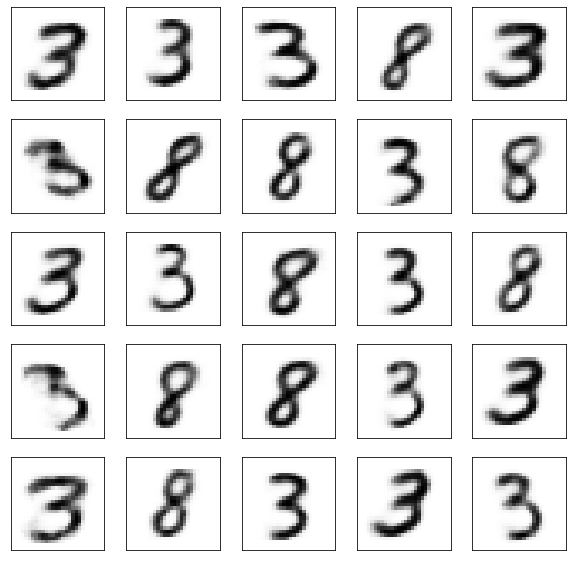

In [94]:
print(encoded_data[1])
test = decode(dec, encoded_data, scaler)
display_image(test, 25)

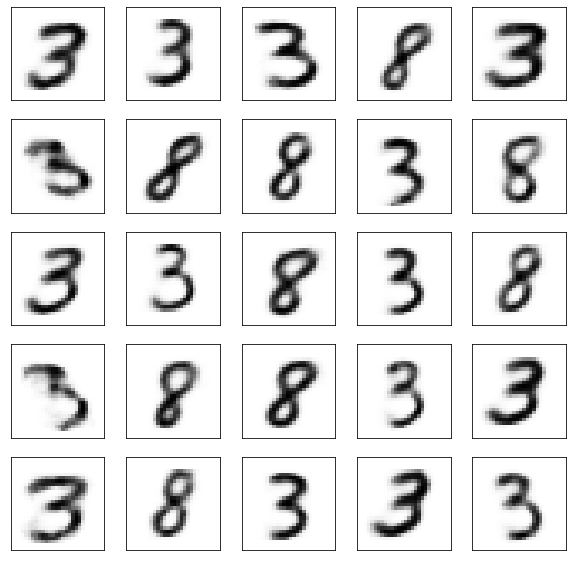

In [95]:
@qml.qnode(dev, interface="tf")
def test_circ(res, data):
    for i in range(0, res):
        qml.RY(data[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

test_data = [test_circ(res, encoded_data[i]) for i in range(25)]
test_img = decode(dec, encoded_data, scaler)
display_image(test_img, 25)

## Initialize weights

In [112]:
disc_weights = tf.Variable(np.pi * np.random.uniform(size=(numWeights,)))
gen_weights = tf.Variable(np.pi * np.random.uniform(size=(numWeights,)))

print(disc_weights)
print(gen_weights)

<tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([0.26654991, 1.50381068, 2.97191966, 0.85620008, 1.29697511,
       1.87150805, 1.42525187, 1.00968071, 0.5856022 , 1.15106965,
       1.69551557])>
<tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([0.5311134 , 2.45053771, 1.11193063, 1.98688636, 0.33470774,
       3.03146223, 2.79557441, 1.75182553, 1.57570817, 1.41816683,
       0.56705082])>


# Generator and Discriminator Models


In [97]:
def generator(thetas, res):
    for i in range(res):
        qml.RY(thetas[i], wires=i+1+res)

    for i in range(res-1):
        qml.IsingYY(thetas[i+res], wires=[i+1+res, i+2+res])
    
    for i in range(res):
        if (i+2)%res == 0:
            qml.CRY(thetas[i+2*res-1], wires=[i+1+res, 2*res])
        else:
            qml.CRY(thetas[i+2*res-1], wires=[i+1+res, ((i+2)%res)+res])

In [98]:
def discriminator(thetas, res):
    for i in range(res):
        qml.RY(thetas[i], wires=i+1)
    
    for i in range(res-1):
        qml.IsingYY(thetas[i+res], wires=[i+1, i+2])
    
    for i in range(res):
        if (i+2)%res == 0:
            qml.CRY(thetas[i+2*res-1], wires=[i+1, res])
        else:
            qml.CRY(thetas[i+2*res-1], wires=[i+1, (i+2)%res])

# Full QGAN Circuit

In [99]:
@qml.qnode(dev, interface="tf")
def createCircuit(disc_weights, gen_weights, res, real=False, real_data=None):
    qml.Hadamard(wires=0)
    discriminator(disc_weights, res)
    if not real:
        generator(gen_weights, res)
        
    if real:
        # Encode real data into Quantum Circuit
        for i in range(0, res):
            qml.RY(real_data[i], wires=i+1+res)
            
    for i in range(res):
        qml.CSWAP(wires=[0, i+1, i+1+res])
    qml.Hadamard(wires=0)

    return qml.expval(qml.PauliZ(0))

# Cost Functions

In [100]:
# def disc_cost(disc_weights, gen_weights, res):
#     real_fidelity = genCircuit(disc_weights, gen_weights, res)
#     gen_fidelity = genCircuit(disc_weights, gen_weights, res, real=False)
#     print(real_fidelity, gen_fidelity)
# #     return m.log(real_fidelity) + m.log(1-gen_fidelity)
#     return tf.math.log(real_fidelity) + tf.math.log(1-gen_fidelity)

# def gen_cost(disc_weights, gen_weights, res):
#     gen_fidelity = genCircuit(disc_weights, gen_weights, res, real=False)
# #     return m.log(gen_fidelity)
#     return tf.math.log(gen_fidelity)

def real_disc_cost(expectation):
    if expectation <= 0.005: # They did in the paper
        expectation = 0.005
    return -tf.math.log(expectation)

def fake_disc_cost(expectation):
    if expectation <= 0.005:
        expectation = 0.005
    return -tf.math.log(1-expectation)
    
def gen_cost(expectation):
    if expectation <= 0.005:
        expectation = 0.005
    return -tf.math.log(expectation) # Maybe incorrect?

In [101]:
def parameter_shift_term(cost, i, params=None):
    if params is None:
        # disc_model (boolean) : which parameters are being shifted, generator's if False.
        # real (boolean) : whether real data is being used
        params = {"disc_model" : True, "real" : False, "real_data" : None}
    if params["disc_model"]:
        shifted = disc_weights.numpy().copy()
        shifted[i] += np.pi/2
        exp = createCircuit(shifted, gen_weights, res, real=params["real"], real_data=params["real_data"])
    else:
        shifted = gen_weights.numpy().copy()
        shifted[i] += np.pi/2
        exp = createCircuit(disc_weights, shifted, res, real=False, real_data=None)
    forward = cost(exp)  # forward evaluation
    
    if params["disc_model"]:
        shifted[i] -= np.pi
        exp = createCircuit(shifted, gen_weights, res, real=params["real"], real_data=params["real_data"])
    else:
        shifted[i] -= np.pi/2
        exp = createCircuit(disc_weights, shifted, res, real=False, real_data=None)
    backward = cost(exp) # backward evaluation

    return (0.5 * (forward.numpy() - backward.numpy()))

In [102]:
def calc_gradient(cost, params):
    grad = [0] * numWeights
    for i in range(numWeights):
        grad[i] = parameter_shift_term(cost, i, params=params)
    return np.array(grad)

In [103]:
params = {"disc_model" : True, "real" : True, "real_data" : encoded_data[0]}
grad = parameter_shift_term(fake_disc_cost, 0, params)
print(grad)

-0.0031244088817265468


In [104]:
grad = calc_gradient(fake_disc_cost, params)
print(grad)

[-0.00312441 -0.03015656 -0.0861232  -0.04130516 -0.00251317 -0.02496583
  0.01098278 -0.00386743  0.0046511  -0.04085846 -0.00212236]


In [105]:
drawer = qml.draw(createCircuit)
print(drawer(disc_weights, gen_weights, res, real=False))

 0: ──H──────────────────────────────────────────────────────────────────────────────────────────────╭C─────╭C─────╭C─────╭C─────H──┤ ⟨Z⟩ 
 1: ──RY(0.47)───╭IsingYY(0.015)──────────────────╭C─────────────────────────────────────╭RY(0.643)──├SWAP──│──────│──────│─────────┤     
 2: ──RY(1.93)───╰IsingYY(0.015)──╭IsingYY(3.07)──╰RY(0.346)───────╭C────────────────────│───────────│──────├SWAP──│──────│─────────┤     
 3: ──RY(0.619)───────────────────╰IsingYY(3.07)──╭IsingYY(0.198)──╰RY(2.5)───╭C─────────│───────────│──────│──────├SWAP──│─────────┤     
 4: ──RY(1.43)────────────────────────────────────╰IsingYY(0.198)─────────────╰RY(1.47)──╰C──────────│──────│──────│──────├SWAP─────┤     
 5: ──RY(3.12)───╭IsingYY(2.83)───────────────────╭C─────────────────────────────────────╭RY(0.858)──╰SWAP──│──────│──────│─────────┤     
 6: ──RY(1.05)───╰IsingYY(2.83)───╭IsingYY(0.48)──╰RY(0.647)───────╭C────────────────────│──────────────────╰SWAP──│──────│─────────┤     
 7: ──RY(2.68)─────────────

# Training Functions

In [106]:
# Function that produces average measurements from trained generator
@qml.qnode(dev)
def generate_output(weights):
    generator(weights, res)
    return [qml.expval(qml.PauliZ(i+res+1)) for i in range(res)]

In [107]:
@qml.qnode(dev, interface="tf")
def gen_loss():
    generator(gen_weights, res)
    return gen_cost(qml.expval(qml.PauliZ(0)))

def train_step(real_data, hp=None):
    global disc_weights, gen_weights
    if hp is None:
        # R (int) : Disc - Gen train count
        hp = {"R" : len(encoded_data), "I" : len(encoded_data) // 10, "batch_size" : 1, "learning_rate" : 0.01}
    # Discriminator on real data
    for i in range(len(real_data)// hp["batch_size"]): 
        average_grad = np.array([0] * numWeights)
        for image in real_data[i*hp["batch_size"]:(i+1)*hp["batch_size"]]:
            params = {"disc_model" : True, "real" : True, "real_data" : image}
            gradient = calc_gradient(real_disc_cost, params) # Have to find the actual format for gradient to use tf.apply_gradients
            average_grad = average_grad + gradient
        average_grad /= hp["batch_size"]
        
        # Apply gradient
        disc_weights = disc_weights - hp["learning_rate"]*average_grad
    # Discriminator on fake data
    for _ in range(hp["R"]):
        print("Discriminator")
        params = {"disc_model" : True, "real" : False, "real_data" : None}
        gradient = calc_gradient(fake_disc_cost, params)
        
        # Apply gradient
        disc_weights = disc_weights - hp["learning_rate"]*gradient
        
    for _ in range(hp["I"]):
        print("Generator")
        params = {"disc_model" : False, "real" : False, "real_data" : None}
        gradient = calc_gradient(gen_cost, params)
        
        gen_weights = gen_weights - 2.5*hp["learning_rate"]*gradient
        # They use 10 times less t"raining steps for generator but a 2.5 times higher learning rate.
        # Apply gradient
    
   

In [108]:
def train(real_data, epochs=25, hp=None):
    for i in range(epochs):
        print("Epoch {} of {}".format(i+1, epochs))
        train_step(real_data, hp)
        # Printing out loss/visualizing examples at certain training steps.
        print("Cost: {}".format(gen_cost(createCircuit(disc_weights, gen_weights, res, real=False))))
        data = (generate_output(gen_weights, shots=num_shots) + 1) / 2
        image = decode(dec, data.reshape(1,-1), scaler)
        display_image(image, 1)

In [76]:
train_step(encoded_data, hp={"R" : 5, "I" : 5, "batch_size" : 5, "learning_rate" : 0.01})

Discriminator
Discriminator
Discriminator
Discriminator


KeyboardInterrupt: 

In [66]:
print(gen_cost(createCircuit(disc_weights, gen_weights, res, real=False)))

tf.Tensor(3.57863410636018, shape=(), dtype=float64)


Epoch 1 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 1.7322099355739977


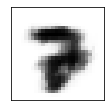

Epoch 2 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 1.6854265416225962


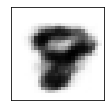

Epoch 3 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 1.6291384660253356


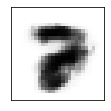

Epoch 4 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 1.561603400408758


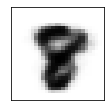

Epoch 5 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 1.481954558924239


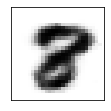

Epoch 6 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 1.3906766653537295


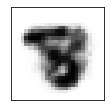

Epoch 7 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 1.2903066302335968


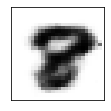

Epoch 8 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 1.1851371933590482


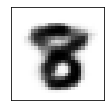

Epoch 9 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 1.0806521665548972


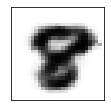

Epoch 10 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.9820661384990778


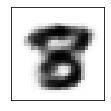

Epoch 11 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.8932742771154254


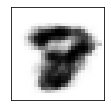

Epoch 12 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.8165700717012782


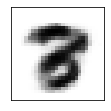

Epoch 13 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.7526177700963688


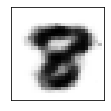

Epoch 14 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.7010504938757551


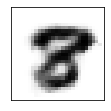

Epoch 15 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.6608644257007329


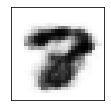

Epoch 16 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.6307738158230554


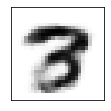

Epoch 17 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.609436407890453


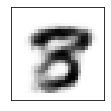

Epoch 18 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.5955988927313614


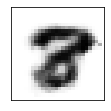

Epoch 19 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.5881376190231055


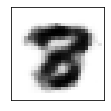

Epoch 20 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.5860185670054603


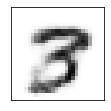

Epoch 21 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.5883410225170337


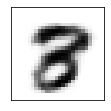

Epoch 22 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.5943350055833129


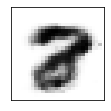

Epoch 23 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.6033398374113345


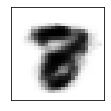

Epoch 24 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.6147924330387092


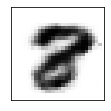

Epoch 25 of 25
Discriminator
Discriminator
Discriminator
Discriminator
Discriminator
Generator
Generator
Generator
Generator
Generator
Cost: 0.6282109371251425


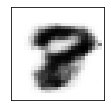

In [113]:
train(encoded_data[:10], hp={"R" : 5, "I" : 5, "batch_size" : 5, "learning_rate" : 0.01})

# Generate Output
Use trained generator to generate MNIST images. 

In [114]:
num_shots = 30
data = (generate_output(gen_weights, shots=num_shots) + 1) / 2
print(data)
image = decode(dec, data.reshape(1,-1), scaler)

[0.8        0.7        0.6        0.63333333]


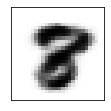

In [115]:
display_image(image, 1)